In [12]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [32]:
from Coil_contribution import Coil_contribution


coils = Coil_contribution()

################################################################PARAMETERS 
###############################################################
# some test coils around the volume
rc=np.zeros(3); zc=np.zeros(3); jc=np.zeros(3)
rc[0]=1.6; zc[0]=  0.1  ; jc[0]=+1.5e4
rc[1]=0.8; zc[1]=  0.3  ; jc[1]=-1e4
rc[2]=0.8; zc[2]= -0.3  ; jc[2]=-1e4



###############################################################



def eval_psi_B0(R,Z):
    '''Evaluates poloidal flux of coil field '''
    

    psi = coils.eval_multi_coil_field(R,Z,r_coils=rc,z_coils=zc,j_coils=jc)

    return psi


def eval_B0pol(R,Z):
    '''Evaluates coil field '''
    
    dpsi_dr,dpsi_dz = coils.eval_grad_multi_coil_field(R,Z,r_coils=rc,z_coils=zc,j_coils=jc)

    return -dpsi_dz/R,dpsi_dr/R




In [33]:

def get_RZ_grid( Rlim=[0.,2.], Zlim=[-1.,1.], h_RZ=1e-2):
    '''Get a meshgrid of a given domain size and uniform approximate grid size h'''
    Nr=int((Rlim[1]-Rlim[0])/h_RZ)
    Nz=int((Zlim[1]-Zlim[0])/h_RZ)
    r = np.linspace(Rlim[0], Rlim[1], Nr)
    z = np.linspace(Zlim[0], Zlim[1], Nz)
    R, Z = np.meshgrid(r, z)
    return R,Z


(0.0, 2.0, -1.0, 1.0)

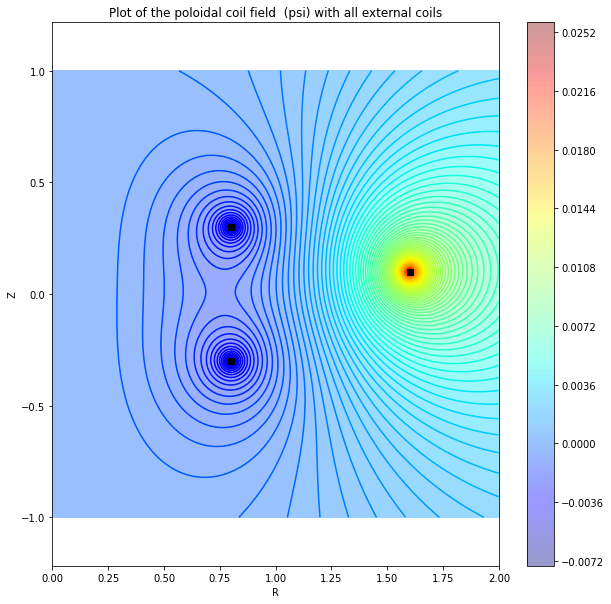

In [34]:
# visualize coil field

R,Z = get_RZ_grid()
psi_c= eval_psi_B0(R,Z)
    

    
    
fig,ax= plt.subplots(figsize=(10,10))
    
im=ax.contourf(R, Z, psi_c, 120, cmap='jet',alpha=0.4)
ax.contour(R, Z, psi_c, 120,cmap='jet')

ax.plot(rc,zc,'ks')
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Plot of the poloidal coil field  (psi) with all external coils')
fig.colorbar(im)
ax.axis("equal")

In [3]:
# READIN reference data: (approximate) flux surface of a dommaschk potential, and the magnetic field evaluated from the dommaschk potential.
varnames=("x","y","z", "Bx","By","Bz","Bdotn","modB")
domm_surf=np.genfromtxt("for_biest_dom25b_R1p0362_inner.dat",dtype=None,names=varnames,skip_header=1)

In [4]:
#extract data:
Nt_max=384
Np_max=384
ref_sol={}
ref_sol[Np_max]={}
for vn in varnames:
    ref_sol[Np_max][vn]=domm_surf[vn].reshape((Nt_max,Np_max))
x=ref_sol[Np_max]["x"]
y=ref_sol[Np_max]["y"]
z=ref_sol[Np_max]["z"]
r=(np.sqrt(x**2+y**2))
print('min/max of r=%f %f' %(np.amin(r),np.amax(r)))
print('min/max of z=%f %f' %(np.amin(z),np.amax(z)))
print('known error in B.n min/max=%e %e' %(np.amin(ref_sol[Np_max]["Bdotn"]),np.amax(ref_sol[Np_max]["Bdotn"])))

min/max of r=0.914338 1.082481
min/max of z=-0.084280 0.084280
known error in B.n min/max=-6.355943e-04 6.355943e-04


(0.9059308507904835,
 1.090887641408542,
 -0.09270746022919041,
 0.09270746022919041)

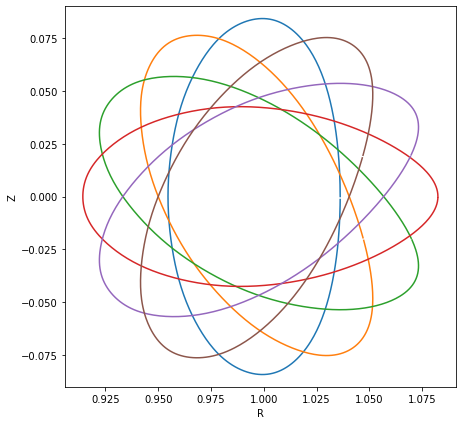

In [5]:
fig,ax= plt.subplots(figsize=(7,7))
for it in range(0,384,64):
   plt.plot(r[it,:],z[it,:])
plt.xlabel('R')
plt.ylabel('Z')
ax.axis("equal")

In [7]:
#extract reference solution for Np=Nt=12,24,...192,[256],384
exp_range=np.arange(7,1,-1)
firstbase=3
# get smaller chunks from the reference
for exp in exp_range[1:]:
    Np=firstbase*2**exp
    print("===> Np= %d" % Np)
    ref_sol[Np]={}
    for vn in varnames:
        ref_sol[Np][vn]=ref_sol[Np*2][vn][0:2*Np:2,0:2*Np:2]
    
firstbase=2
exp_range=np.arange(6,1,-1)
Np=firstbase*2**exp_range[0]
print("===> Np= %d" % Np)
ref_sol[Np]={}
for vn in varnames:
    ref_sol[Np][vn]=ref_sol[Np*3][vn][0:3*Np:3,0:3*Np:3]

for exp in exp_range[1:]:
    Np=firstbase*2**exp
    print("===> Np= %d" % Np)
    ref_sol[Np]={}
    for vn in varnames:
        ref_sol[Np][vn]=ref_sol[Np*2][vn][0:2*Np:2,0:2*Np:2]


===> Np= 192
===> Np= 96
===> Np= 48
===> Np= 24
===> Np= 12
===> Np= 128
===> Np= 64
===> Np= 32
===> Np= 16
===> Np= 8


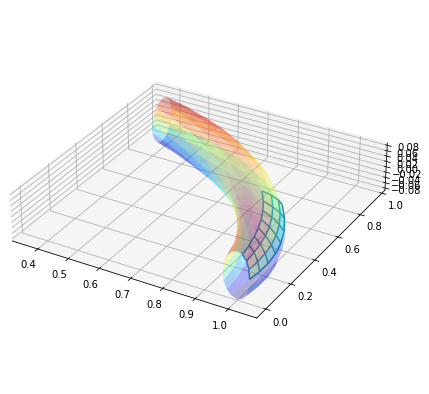

In [31]:
from matplotlib import cm
%matplotlib inline

Np=16

ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')

ax.plot_wireframe(ref_sol[Np]["x"][0:8,0:4],ref_sol[Np]["y"][0:8,0:4],ref_sol[Np]["z"][0:8,0:4])
ax.plot_surface(ref_sol[Np]["x"],ref_sol[Np]["y"],ref_sol[Np]["z"],alpha=0.3,cmap=cm.jet)
ax.set_box_aspect((1.,1.,0.2))

In [66]:
#################
#### COMPUTE BIEST RESULTS, 3D VERSION, USING AXISYMMETRIC REFERENCE CASE
#################


import vacuum_field as vacfield

vf = vacfield.vacuum_field()
#vacuum_field.Setup(digits, NFP, Nt, Np, X, Nt, Np);

axisymm=False
if(axisymm):    
    vf_digits=14  # accuracy of the boundary integral method, measured in digits
    vf_Nt=1    # allows BIEST to select the axi-symmetric mode
    vf_NFP=5   # needed in axisymmetric mode (for integration points!)
    Np_range=[8,12,16,24,32,48,64,96,128]#,192,256]
    NteqNp=False
    screw=0 # number of poloidal turns in one toroidal turn... must be zero for axisymm
else:
    vf_digits=14
    vf_Nt=4
    vf_NFP=5
    Np_range=[8,16,32]#,48,64]#,96,128]#,192,256]
    NteqNp=True # same Nt as Np!
    screw=-1 # number of poloidal turns in one toroidal turn (-2,-1,0,1,2,...). Making the axisymmetric surface "really 3D"

factor_Np=1
factor_Nt=1
vf_Nt_out=factor_Nt*vf_Nt
    

# switch between B0+Jplasma=0, and Bcoil + real Jplasma
Jplasma=0.



vf_results_3D={"Np_range":Np_range}
case="Dommaschk"
if(case):
        vf_results_3D[case]={}
        vf_res=vf_results_3D[case]
        vf_res["max.err Bh_x"]=[]
        vf_res["max.err Bh_y"]=[]
        vf_res["max.err Bh_z"]=[]
        vf_res["max.err Bh.N/|Bh|"]=[]
        vf_res["max.err Bref.N/|Bref|"]=[]
        vf_res["max |gradPhi_R|"]=[]
        vf_res["max |gradPhi_Z|"]=[]
        vf_res["max |gradPhi_phi|"]=[]
        
        for vf_Np in Np_range:
            vf_Np_out=factor_Np*vf_Np
            if(NteqNp):
                vf_Nt=vf_Np
                vf_Nt_out=vf_Np_out
            else:
                break
            print("     ===> Np=%d, Np_out=%d Nt=%d, Nt_out=%d"%(vf_Np,vf_Np_out,vf_Nt,vf_Nt_out))  
            
            phitor    =2*np.pi/vf_NFP*np.linspace(0.,1.,vf_Nt,endpoint=False)
            phitor_out=2*np.pi/vf_NFP*np.linspace(0.,1.,vf_Nt_out,endpoint=False)

            cosmat = np.outer(np.cos(phitor_out),np.ones(vf_Np_out))
            sinmat = np.outer(np.sin(phitor_out),np.ones(vf_Np_out))
            XX=np.zeros((3,vf_Nt,vf_Np))
            RR=np.zeros((vf_Nt,vf_Np))
            ZZ=np.zeros((vf_Nt,vf_Np))
            RR_out=np.zeros((vf_Nt_out,vf_Np_out))
            ZZ_out=np.zeros((vf_Nt_out,vf_Np_out))
            print("       ===> get surface")
            #rr,zz=get_curve(x_final,xmap,vf_Np,rzcorr,thet_offset=0.)
            if(vf_Np_out in ref_sol.keys()):
                RR_out=np.sqrt(ref_sol[vf_Np_out]["x"]**2+ref_sol[vf_Np_out]["y"]**2)
                ZZ_out=ref_sol[vf_Np_out]["z"]
            else:        
                break
            if(vf_Np in ref_sol.keys()):
                RR=np.sqrt(ref_sol[vf_Np]["x"]**2+ref_sol[vf_Np]["y"]**2)
                ZZ=ref_sol[vf_Np]["z"]
                print("check x diff: %e" % (np.amax(np.abs(ref_sol[vf_Np]["x"]-RR*np.outer(np.cos(phitor),np.ones(vf_Np))))))
                print("check y diff: %e" % (np.amax(np.abs(ref_sol[vf_Np]["y"]-RR*np.outer(np.sin(phitor),np.ones(vf_Np))))))
            else:        
                break             
            #prepare array for BIEST, x,y,z coordinates
            XX[0,:,:]=RR*np.outer(np.cos(phitor),np.ones(vf_Np))
            XX[1,:,:]=RR*np.outer(np.sin(phitor),np.ones(vf_Np))
            XX[2,:,:]=ZZ
            print("       ===> surface setup finished.")
            

            #prepare B0 data
            B0_R=np.zeros((vf_Nt_out,vf_Np_out))
            B0_Z=np.zeros((vf_Nt_out,vf_Np_out))
            #B0_R,B0_Z=eval_B0pol(RR_out.flatten(),ZZ_out.flatten())
            
            B0_R  =B0_R.reshape((vf_Nt_out,vf_Np_out))
            B0_Z  =B0_Z.reshape((vf_Nt_out,vf_Np_out))
            B0_phi=2.#/RR_out
            # Bx,By,Bz
            B0=np.zeros((3,vf_Nt_out,vf_Np_out))
            B0[0,:,:]=( B0_R  *cosmat - B0_phi * sinmat )
            B0[1,:,:]=( B0_R  *sinmat + B0_phi * cosmat )
            B0[2,:,:]=  B0_Z 
            
          
            #solution steps in BIEST
            print("       ===> Biest setup") 
            vf.Setup(vf_digits,vf_NFP,vf_Nt,vf_Np,XX.flatten(),vf_Nt_out,vf_Np_out)
            
            #test=np.zeros((3,vf_Nt_out,vf_Np_out))
            #N=np.zeros((3,vf_Nt_out,vf_Np_out))
            #for dd in [0,1,2]:
            #    test[dd,:,:]=1.
            #    N[dd,:,:]=np.asarray(vf.ComputeBdotN(test.flatten())).reshape((vf_Nt_out,vf_Np_out))
            #    test[dd,:,:]=0.
            #print("x/y/z",XX[:,0,0],"Nx/y/z",N[:,0,0])
            #print("x/y/z",XX[:,0,int(vf_Np/4)],"Nx/y/z",N[:,0,int(vf_Np_out/4)])
            print("       ===> Biest solve") 
            B0dotN=vf.ComputeBdotN(B0.flatten())
            
            ### OLD VERSION OF BIEST (Jplasma=0.)
            ### gradPhi,sigma=vf.ComputeGradPhi(B0dotN)
            ### gradPhi=np.asarray(gradPhi).reshape((3,vf_Nt_out,vf_Np_out))
            Bplasma,sigma,B_Jplasma=vf.ComputeBplasma(B0dotN,Jplasma) # Jplasma=0 with B0!
            gradPhi=-np.asarray(Bplasma).reshape((3,vf_Nt_out,vf_Np_out))
            print("       ===> Biest finished") 
            B_JplasmadotN=vf.ComputeBdotN(B_Jplasma)
            print ("max |B_Jplasma.N|= %e " % np.amax(np.abs(np.asarray(B_JplasmadotN))))
            
            #Bh=-gradPhi
            
            gradPhi_R  =( gradPhi[0,:,:]*cosmat +gradPhi[1,:,:]*sinmat)
            gradPhi_phi=(-gradPhi[0,:,:]*sinmat +gradPhi[1,:,:]*cosmat)
            gradPhi_Z  =  gradPhi[2,:,:]
            

            Bh_R=B0_R-gradPhi_R
            Bh_Z=B0_Z-gradPhi_Z
            Bh_phi=B0_phi-gradPhi_phi
            Bh=np.zeros((3,vf_Nt_out,vf_Np_out))
            Bh=B0-gradPhi
            


            #Bref_R,Bref_Z=eval_full_Bpol(RR_out.flatten(),ZZ_out.flatten())
            #Bref_R  =Bref_R.reshape((vf_Nt_out,vf_Np_out))
            #Bref_Z  =Bref_Z.reshape((vf_Nt_out,vf_Np_out))
            #Bref_phi=1./RR_out
            
            Bref=np.zeros((3,vf_Nt_out,vf_Np_out))
            Bref[0,:,:]=ref_sol[vf_Np_out]["Bx"]
            Bref[1,:,:]=ref_sol[vf_Np_out]["By"]
            Bref[2,:,:]=ref_sol[vf_Np_out]["Bz"]
            hp=int(vf_Np/2)
            for j in range(0,2):
                for i in range(0,2):
                    print("Bref[",i,j,"]=",Bref[:,j*hp,i*hp])
                    print("Bh  [",i,j,"]=",Bh[:,j*hp,i*hp])
    

            vf_res["max.err Bh_x"].append(np.amax(np.abs(Bh[0,:,:]-Bref[0,:,:])))
            vf_res["max.err Bh_y"].append(np.amax(np.abs(Bh[1,:,:]-Bref[1,:,:])))
            vf_res["max.err Bh_z"].append(np.amax(np.abs(Bh[2,:,:]-Bref[2,:,:])))
            print ("max err Bh_x/z  = %e %e" % (vf_res["max.err Bh_x"][-1],vf_res["max.err Bh_z"][-1]))

            vf_res["max |gradPhi_R|"].append(np.amax(np.abs(gradPhi_R)))
            vf_res["max |gradPhi_Z|"].append(np.amax(np.abs(gradPhi_Z)))
            vf_res["max |gradPhi_phi|"].append(np.amax(np.abs(gradPhi_phi)))
            print ("max |gradPhi_R/Z/phi|= %e %e %e " % (vf_res["max |gradPhi_R|"][-1],vf_res["max |gradPhi_Z|"][-1],vf_res["max |gradPhi_phi|"][-1]))

            
            BhdotN=vf.ComputeBdotN(Bh.flatten())
            vf_res["max.err Bh.N/|Bh|"].append(np.amax(np.abs(BhdotN/np.sqrt(Bh[0,:,:].flatten()**2+Bh[1,:,:].flatten()**2+Bh[2,:,:].flatten()**2))))
            print ("maximum error in Bh.N/|Bh|= %e" % (vf_res["max.err Bh.N/|Bh|"][-1]))
            BrefdotN=vf.ComputeBdotN(Bref.flatten())
            vf_res["max.err Bref.N/|Bref|"].append(np.amax(np.abs(BrefdotN/np.sqrt(Bref[0,:,:].flatten()**2+Bref[1,:,:].flatten()**2+Bref[2,:,:].flatten()**2))))
            print ("maximum error in Bref.N/|Bref|= %e" % (vf_res["max.err Bref.N/|Bref|"][-1]))

     ===> Np=8, Np_out=8 Nt=8, Nt_out=8
       ===> get surface
check x diff: 4.773959e-15
check y diff: 1.304512e-14
       ===> surface setup finished.
       ===> Biest setup
       ===> Biest solve
       ===> Biest finished
max |B_Jplasma.N|= 0.000000e+00 
Bref[ 0 0 ]= [ 0.          0.97094206 -0.05322843]
Bh  [ 0 0 ]= [-5.23511578e-13  1.98342690e+00  1.71946452e-01]
Bref[ 1 0 ]= [-1.64299930e-17  1.05780100e+00  6.96963782e-02]
Bh  [ 1 0 ]= [ 5.53036776e-14  1.97916526e+00 -1.83421713e-01]
Bref[ 0 1 ]= [-0.52571704  0.72358742  0.12112394]
Bh  [ 0 1 ]= [-1.21077313  1.66648624 -0.25394709]
Bref[ 1 1 ]= [-0.6193547   0.85246862 -0.13784836]
Bh  [ 1 1 ]= [-1.21439173  1.67146682  0.24958985]
max err Bh_x/z  = 1.029132e+00 3.874382e-01
max |gradPhi_R/Z/phi|= 2.907156e-01 2.687680e-01 6.604662e-02 
maximum error in Bh.N/|Bh|= 3.506501e-15
maximum error in Bref.N/|Bref|= 9.892419e-04
     ===> Np=16, Np_out=16 Nt=16, Nt_out=16
       ===> get surface
check x diff: 5.218048e-15
check 

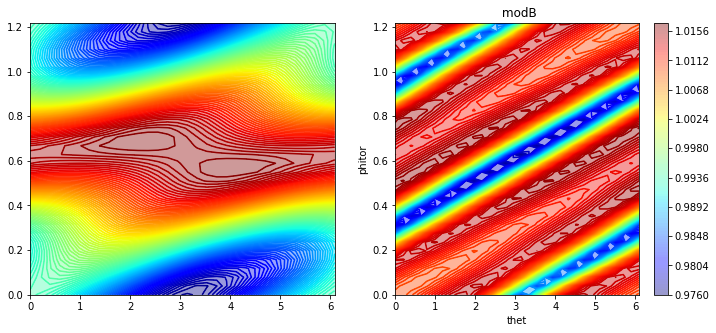

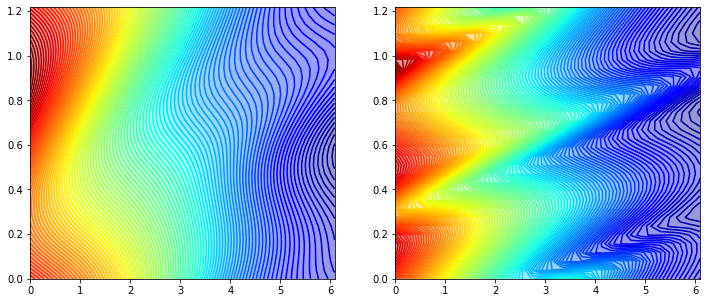

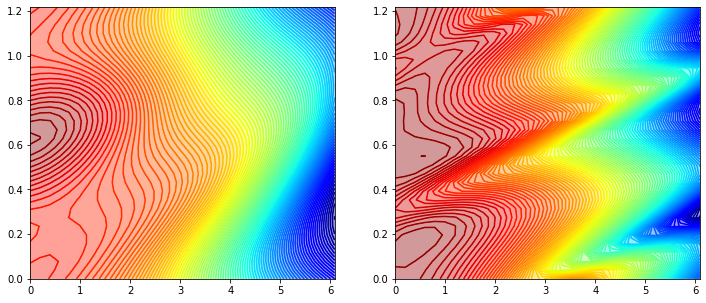

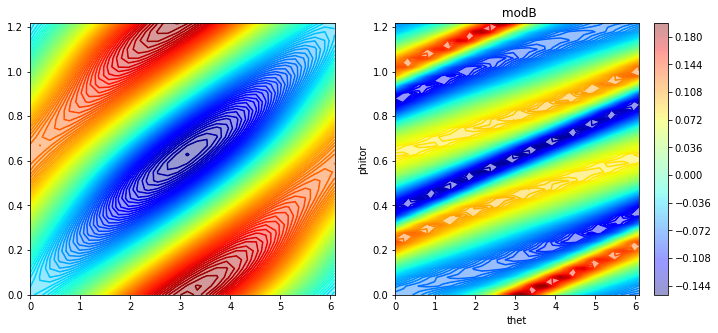

In [63]:
thet    =2*np.pi*np.linspace(0.,1.,vf_Np,endpoint=False) 
v,u=np.meshgrid(phitor,thet)
#modB=ref_sol[vf_Np]["modB"]
modB=np.sqrt(Bref[0,:,:]**2+Bref[1,:,:]**2+Bref[2,:,:]**2)
fig,ax= plt.subplots(1,2,figsize=(12,5))
im=ax[0].contourf(u, v,modB, 120, cmap='jet',alpha=0.4)
ax[0].contour(u, v,modB, 120,cmap='jet')

modB=np.sqrt(Bh[0,:,:]**2+Bh[1,:,:]**2+Bh[2,:,:]**2)
im=ax[1].contourf(u, v,modB, 120, cmap='jet',alpha=0.4)
ax[1].contour(u, v,modB, 120,cmap='jet')

plt.xlabel('thet')
plt.ylabel('phitor')
plt.title(' modB')
fig.colorbar(im)
for comp in range(0,3):
    fig,ax= plt.subplots(1,2,figsize=(12,5))
    im=ax[0].contourf(u, v,Bref[comp,:,:], 120, cmap='jet',alpha=0.4)
    ax[0].contour(u, v,Bref[comp,:,:], 120,cmap='jet')

     
    im=ax[1].contourf(u, v,Bh[comp,:,:], 120, cmap='jet',alpha=0.4)
    ax[1].contour(u, v,Bh[comp,:,:], 120,cmap='jet')

plt.xlabel('thet')
plt.ylabel('phitor')
plt.title(' modB')
fig.colorbar(im)

#ax.axis("equal")

In [ ]:
glob_res={}
xxcase="dommaschk"
print('add result '+xxcase)
glob_res[xxcase]=vf_results_3D

In [ ]:
selectB0case="dommaschk" 
res=glob_res[selectB0case]

sub_keys=["max.err Bh_R",
          "max.err Bh_Z",
          "max.err Bref.N/|Bref|",
          "max.err Bh.N/|Bh|",
          ]
#if(True):          
#    fig, ax = plt.subplots()
#    ax.set_xscale('log', base=2)
#    ax.set_yscale('log', base=10)
for main_key in main_keys:
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=10)
    for key in sub_keys:
        plt.plot(Np_range, res[key],label=key)

#if(True): 
    if(NteqNp):
        plt.xlabel('resolution Np=Nt')
    else:
        plt.xlabel('resolution Np')
    plt.ylabel('error')
    plt.ylim([1e-16, 1e-0])
    plt.title('BIEST vacuum field error analysis  ["'+selectB0case+'","'+main_key+'"]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('BIEST_vf_err_'+selectB0case+'_'+main_key.replace(" ","").replace(',','_')+'.pdf',bbox_inches='tight' ) 
    plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)


#Brefcase="Bref_symm"
#cases =["B0unsymm","B0same","B0unsymm_Jpl"]
#labs = ["[B0unsymm]","[B0same]","[Jplasma]"]
Brefcase="Bref_unsymm"
add="_axisymm4Np"
cases =["B0extreme"+add,"B0same"+add,"B0extreme"+add+"_Jpl"]
labs = ["[B0extreme]","[B0same]","[Jplasma]"]


for cs,lb in zip(cases,labs):
    plt.plot(Np_range, glob_res[Brefcase+"_"+cs]["m_max=6, rzcorr"]["max.err Bh_R"],label=lb)
#plt.plot(Np_range, glob_res[Brefcase+"_"+cases[0]]["m_max=6, rzcorr"]["max.err Bref.N/|Bref|"],label="max.err Bref.N/|Bref|")

if(True): 
    if(NteqNp):
        plt.xlabel('resolution Np=Nt')
    else:
        plt.xlabel('resolution Np')
    plt.ylabel('max.err Bh_R ')
    plt.ylim([1e-16, 1e-0])
    #plt.title('BIEST vacuum field error analysis  ["'+selectB0case+'","'+main_key+'"]')
    plt.title('BIEST vacuum field error analysis  ["'+Brefcase+add+'"]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig('BIEST_vf_err_comparison_'+Brefcase+add+'.pdf',bbox_inches='tight' ) 
    plt.show()

In [ ]:
selectB0case="B0unsymm"
res=glob_res[selectB0case]
main_keys=["m_max=4, no rzcorr",
           "m_max=6, no rzcorr",
           "m_max=9, no rzcorr",
           "m_max=12, no rzcorr",
           "m_max=4, rzcorr",
           "m_max=6, rzcorr",
           "m_max=9, rzcorr",
           "m_max=12, rzcorr",
          ]
sub_keys=["max.err Bref.N/|Bref|",
          ]
       
fig, ax = plt.subplots()
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)
for main_key in main_keys:
    for key in sub_keys:
        plt.plot(Np_range, res[main_key][key],label=main_key)


plt.xlabel('resolution Np')
plt.ylabel('error  in $|B_{ref}\cdot N|/|B_{ref}|$')
#plt.ylim([1e-12, 1e-1])
plt.title("Error of the curve approximation, without/with correction ")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('error_curve_approx.pdf',bbox_inches='tight' )  
plt.show()


In [ ]:


from matplotlib import cm

res=results["m_max=6"]
x_final,xmap=res["x_final"],res["xmap"]
vf_NFP=1
vf_Nt=32
vf_Np=32
screw=-2
rzcorr=0

phitor    =2*np.pi/vf_NFP*np.linspace(0.,1.,vf_Nt,endpoint=False)

XX=np.zeros((3,vf_Nt,vf_Np))
RR=np.zeros((vf_Nt,vf_Np))
ZZ=np.zeros((vf_Nt,vf_Np))
#for it in range(0,vf_Nt):
#    RR[it,:],ZZ[it,:]=get_curve(x_final,xmap,vf_Np,rzcorr,thet_offset=screw*(it/vf_Nt))

rr,zz=get_curve(x_final,xmap,vf_Np,rzcorr,thet_offset=0.)
for it in range(0,vf_Nt):
    RR[it,:]=rr[np.arange(0+screw*it,vf_Np+screw*it) % vf_Np ] 
    ZZ[it,:]=zz[np.arange(0+screw*it,vf_Np+screw*it) % vf_Np ]

#prepare array for BIEST, x,y,z coordinates
XX[0,:,:]=RR*np.outer(np.cos(phitor),np.ones(vf_Np))
XX[1,:,:]=RR*np.outer(np.sin(phitor),np.ones(vf_Np))
XX[2,:,:]=ZZ
print("       ===> surface setup finished.")

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.plot_wireframe(XX[0,:,:],XX[1,:,:],XX[2,:,:])
ax.plot_surface(XX[0,:,:],XX[1,:,:],XX[2,:,:],alpha=0.9,cmap=cm.jet)
ax.set_box_aspect((5.,5.,1.))

In [ ]:
#backup 3D case 
case="Bref_unsymm_B0differs_3D"
vf_NFP=1
screw=1
NteqNp=True
Np_range = [8,12,16,24,32,48,64,96,]
vf_results_3D={"Np_range":Np_range}
vf_results_3D["m_max=6, rzcorr"]={}
vf_res=vf_results_3D["m_max=6, rzcorr"]


vf_res["max.err Bh_R"]    =   [3.447468e-03 , 1.057053e-03,7.047258e-07,1.349085e-06,1.056449e-07,1.445861e-08,4.855910e-10,1.054906e-12,]
vf_res["max.err Bh_Z"]    =   [3.454906e-03 , 9.098912e-04,7.593146e-07,1.227674e-06,1.151647e-07,1.332503e-08,4.359148e-10,9.622945e-13,]
vf_res["max |gradPhi_R|"]  =  [5.505052e-03 , 5.127163e-03,4.911439e-03,4.911506e-03,4.921319e-03,4.935281e-03,4.935806e-03,4.935278e-03,]
vf_res["max |gradPhi_Z|"]  =  [5.141133e-03 , 4.879587e-03,4.665479e-03,4.665692e-03,4.665496e-03,4.666958e-03,4.673057e-03,4.674833e-03,]
vf_res["max |gradPhi_phi|"]  =[1.013466e-03 , 5.387055e-04,2.676764e-08,5.343291e-07,4.401681e-08,6.364176e-09,2.107727e-10,4.749381e-13,]
vf_res["max.err Bh.N/|Bh|"]=[8.624617e-15 , 8.482391e-15,1.582838e-14,1.142498e-14,1.762623e-14,1.774175e-14,8.962142e-14,5.145447e-14,]
vf_res["max.err Bref.N/|Bref|"]= [3.424623e-01, 1.314821e-01, 7.560868e-05,1.336166e-04,3.076877e-05,2.572690e-06,7.097624e-08,1.882949e-10,]

glob_res={}
glob_res[case]=vf_results_3D

In [ ]:
glob_res